### 3.2.2 Резонанс напряжений в последовательном контуре

In [1]:
import pandas as pd
import numpy as np
import mygraph as mg

filename = 'table.tsv'
df = pd.read_csv(filename,sep='\t')
df.index = np.arange(1,8)
df['L, мкГн'] = np.zeros_like(df.index)
df['Q'] = np.zeros_like(df.index)
df['p, Ом'] = np.zeros_like(df.index)
df['R_sum, Ом'] = np.zeros_like(df.index)
df['R_s_max, Ом'] = np.zeros_like(df.index)
df['R_L, Ом'] = np.zeros_like(df.index)
df['I, мА'] = np.zeros_like(df.index)
# df['U, V'] *= np.sqrt(2) # см. тетрадь
df

,"C, нФ","f, kHz","U, V","E, V","L, мкГн",Q,"p, Ом","R_sum, Ом","R_s_max, Ом","R_L, Ом","I, мА"
1,25.0,31.272,6.1440,0.2511,0,0,0,0,0,0,0
2,33.2,27.313,5.3790,0.2510,0,0,0,0,0,0,0
3,47.5,22.864,4.7394,0.2511,0,0,0,0,0,0,0
4,57.2,20.898,4.2560,0.2509,0,0,0,0,0,0,0
5,67.4,19.330,3.7715,0.2507,0,0,0,0,0,0,0
6,82.1,17.535,3.7232,0.2506,0,0,0,0,0,0,0
7,99.6,15.955,3.5193,0.2506,0,0,0,0,0,0,0


In [2]:
import numpy as np
def L(C, nu):
    ''' [w] = kHz, [C] = nF => [L] = кГн '''
    w = 2 * np.pi * nu
    return ( 1 / (w*w*C) ) * 1e9

def Q(Uc, eps0):
    return Uc / eps0

def rho(L, C):
    ''' [L] = мкГн, [C] = nF => [rho] = Om '''
    L *= 1e3 # [L] = нГн
    return np.sqrt(L / C)

def R_sum(Q, p):
    return p / Q

def R_s(p, tgd=1e-3):
    return p * tgd

def R_L(R_sum, R_s, R=3.45):
    return R_sum - R_s - R

def I(eps0, R_sum):
    return (eps0 / R_sum) * 1e3

df['L, мкГн']     = [ L(c, w) for c, w in zip( df['C, нФ'], df['f, kHz'] ) ]
df['Q']           = [ Q(u, eps) for u, eps in zip( df['U, V'], df['E, V'] ) ]
df['p, Ом']       = [ rho(l, c) for l, c in zip( df['L, мкГн'], df['C, нФ'] ) ]
df['R_sum, Ом']   = [ R_sum(q, p) for q, p in zip( df['Q'], df['p, Ом'] ) ] 
df['R_s_max, Ом'] = [ R_s(p) for p in df['p, Ом'] ]
df['R_L, Ом']     = [ R_L(r_sum, r_s) for r_sum, r_s in zip( df['R_sum, Ом'], df['R_s_max, Ом'] ) ] 
df['I, мА']       = [ I(eps, R_sum) for eps, R_sum in zip( df['E, V'], df['R_sum, Ом'] ) ]
s_u = 1e-3 # В
sigma_Q = s_u / df['E, V'].min()
print(f'Погрешность Q в таблице = {sigma_Q}')
df

Погрешность Q в таблице = 0.0039904229848363925


,"C, нФ","f, kHz","U, V","E, V","L, мкГн",Q,"p, Ом","R_sum, Ом","R_s_max, Ом","R_L, Ом","I, мА"
1,25.0,31.272,6.1440,0.2511,1036.069621,24.468339,203.575010,8.319936,0.203575,4.666361,30.180522
2,33.2,27.313,5.3790,0.2510,1022.735592,21.430279,175.514355,8.190017,0.175514,4.564503,30.647066
3,47.5,22.864,4.7394,0.2511,1020.098786,18.874552,146.546115,7.764217,0.146546,4.167671,32.340673
4,57.2,20.898,4.2560,0.2509,1013.992598,16.962933,133.143319,7.849074,0.133143,4.265931,31.965554
5,67.4,19.330,3.7715,0.2507,1005.811643,15.043877,122.159819,8.120235,0.122160,4.548075,30.873490
6,82.1,17.535,3.7232,0.2506,1003.426499,14.857143,110.553171,7.441079,0.110553,3.880526,33.677912
7,99.6,15.955,3.5193,0.2506,999.050192,14.043496,100.153005,7.131629,0.100153,3.581476,35.139235


In [3]:
mean_vals = {
    'L': 0.,
    'R_L': 0.,
    'sigmaL': .0,
    'sigmaR_L': 0,
    'devL': 0,
    'devR_L': 0 
}
mean_vals['L']   = df['L, мкГн'].mean() 
mean_vals['R_L'] = df['R_L, Ом'].mean()
ser = pd.Series(mean_vals)

s_f = 1
s_c = 0.1 * 1e-9
C = np.min(df['C, нФ']) * 1e-9
f = np.min(df['f, kHz']) * 1e3
ser['sigmaL'] = np.sqrt(
    np.square( 2 * s_f / (4*np.pi*np.pi*C*f*f*f) ) +\
    np.square( s_c / (4*np.pi*np.pi*f*f*C*C) )
) * 1e6

s_u = 1e-4
eps = df['E, V'].min()
U = df['U, V'].min()

ser['sigmaR_L'] = np.sqrt(
    np.square( (1e-3/(2*np.pi*f*f*C) - eps/(2*np.pi*C*U*f*f)) * s_f ) +\
    np.square( (1e-3/(2*np.pi*f*C*C) - eps/(2*np.pi*f*C*C*U)) * s_c ) +\
    np.square( (eps/(2*np.pi*f*C*U)) * s_u )    
)
ser['devL']   = np.std( df['L, мкГн'], ddof=1 ) / np.sqrt( len(df['L, мкГн']) )
ser['devR_L'] = np.std( df['R_L, Ом'], ddof=1 ) / np.sqrt( len(df['R_L, Ом']) )
ser

L           1014.454990
R_L            4.239220
sigmaL        15.928680
sigmaR_L       0.112103
devL           4.883085
devR_L         0.150457
dtype: float64

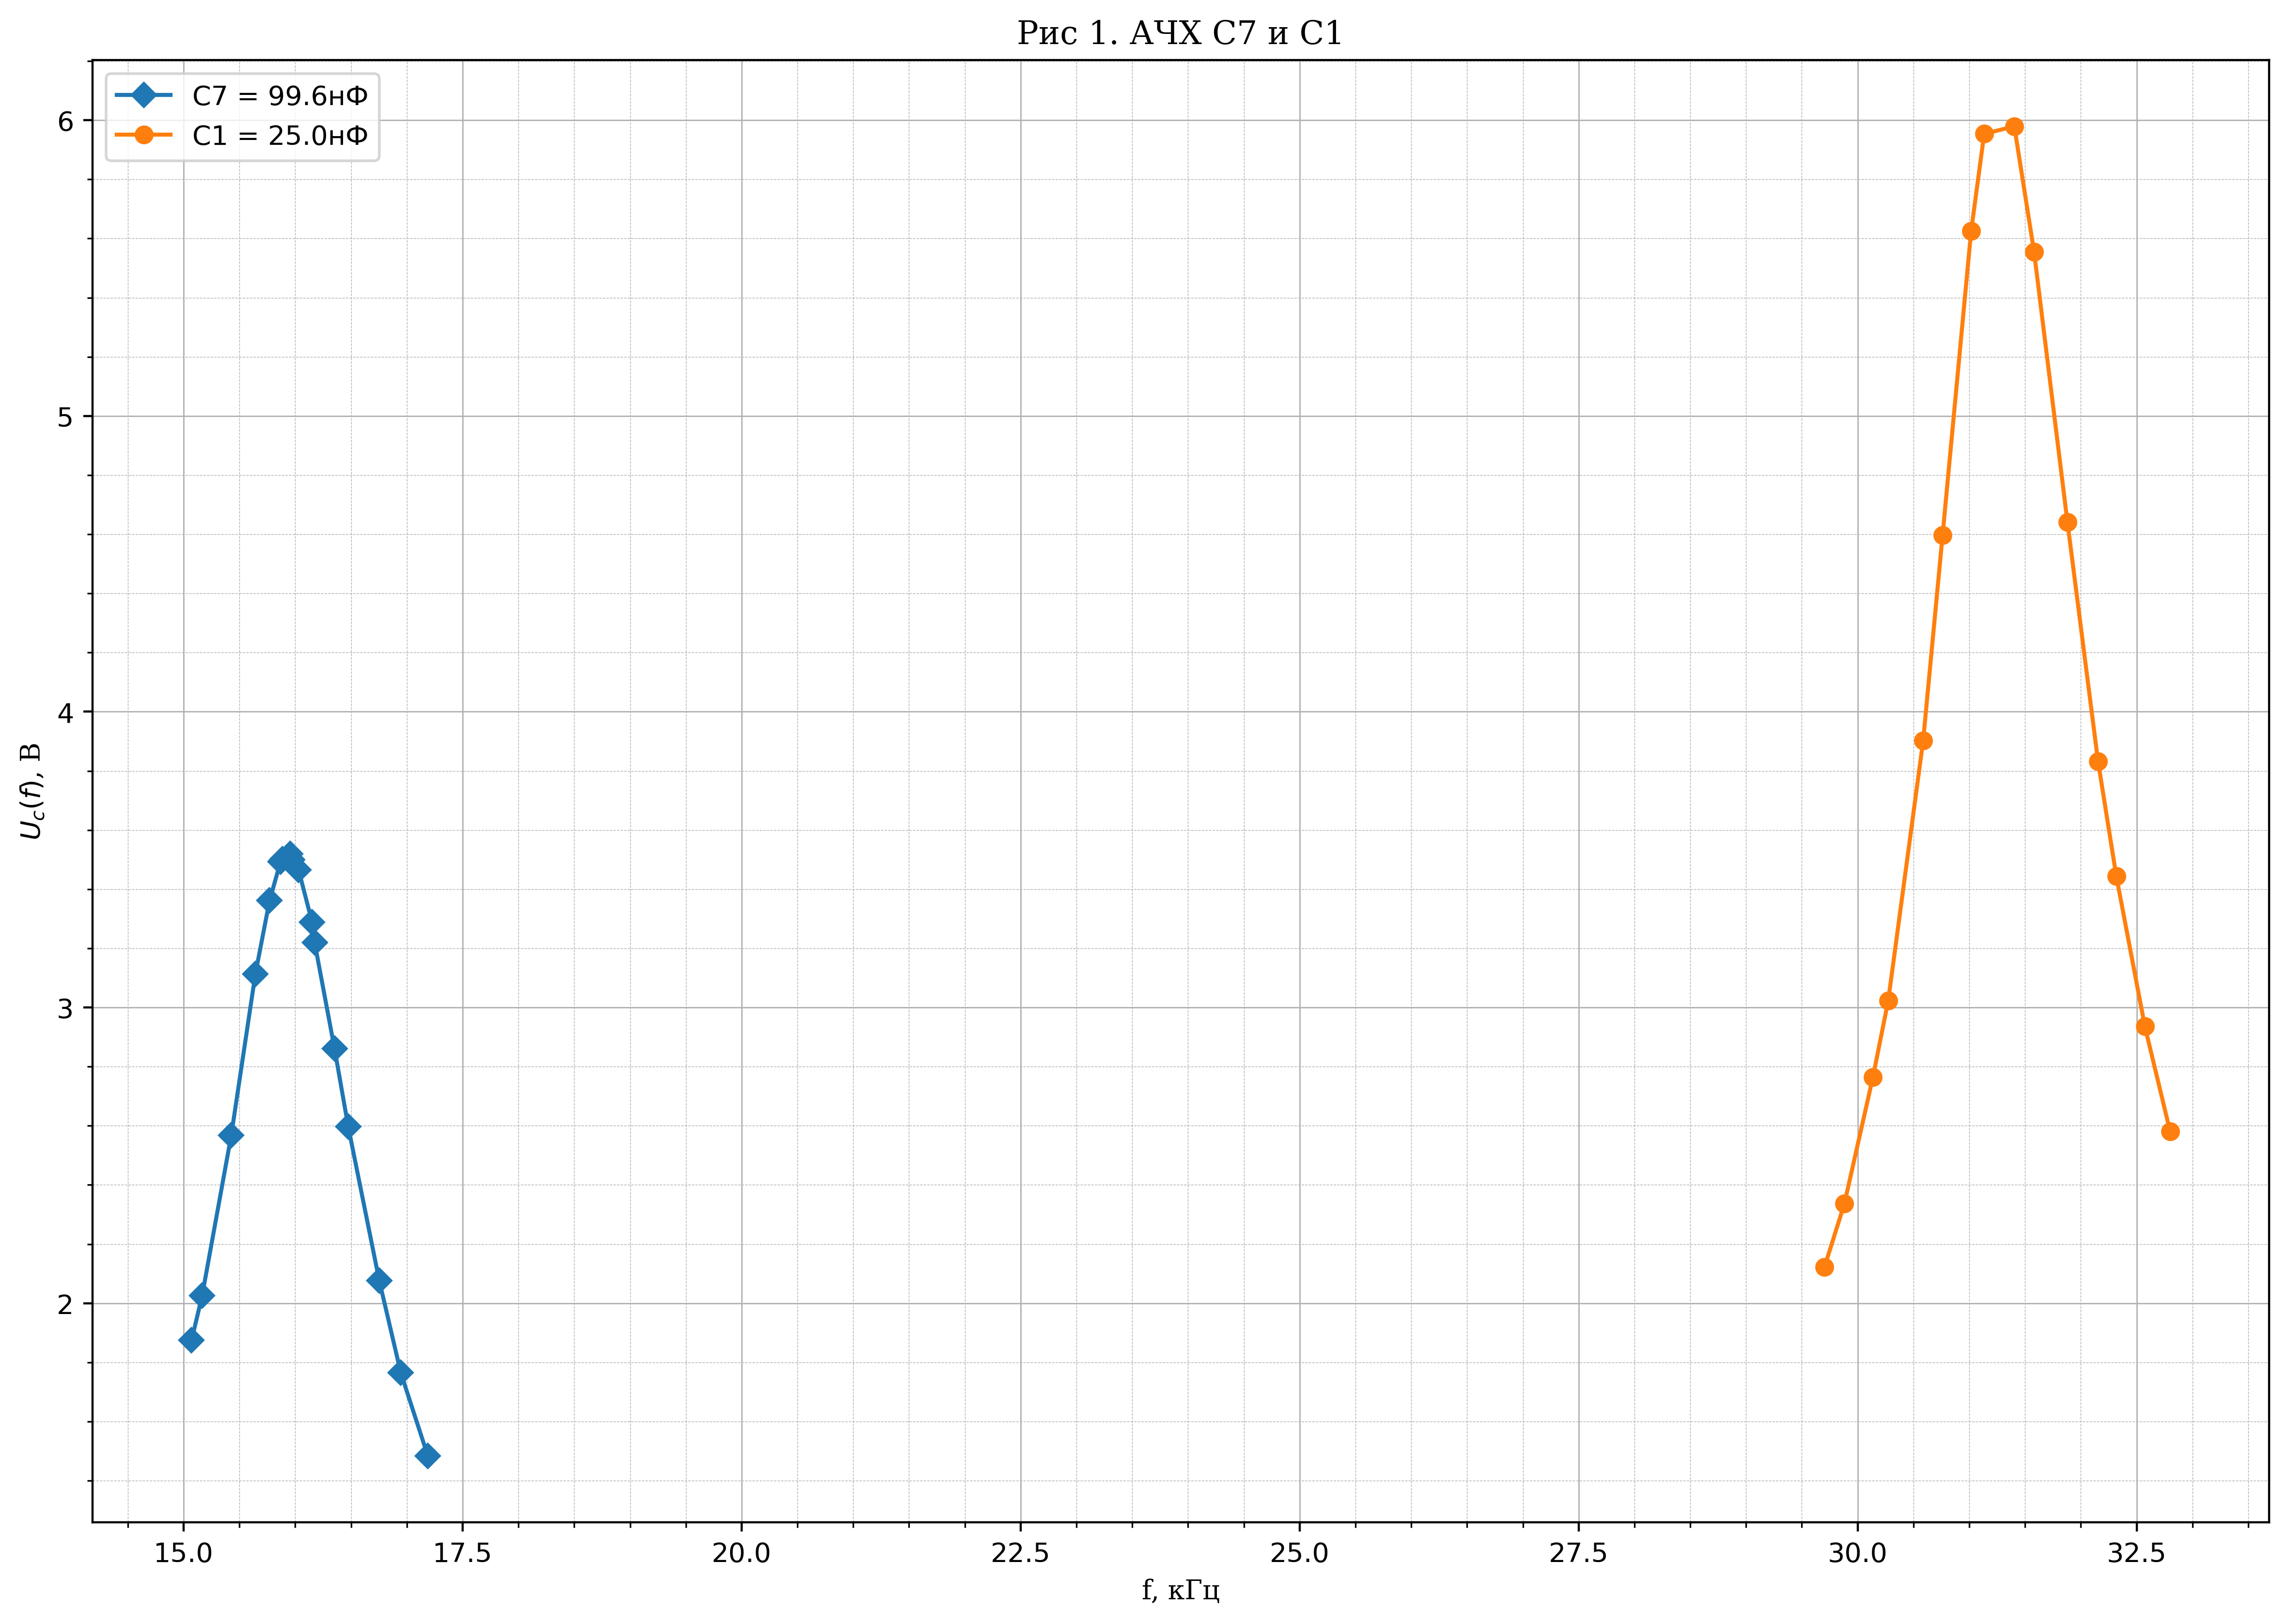

In [4]:
import pandas as pd
import mygraph as mg
import matplotlib.pyplot as plt

filename = 'c7ampl.tsv'
dfc7a = pd.read_csv(filename, sep='\t')
dfc7a.index = np.arange(1,18)
# dfc7a['U, V'] *= np.sqrt(2) # см. тетрадь
filename = 'c1ampl.tsv'
dfc1a = pd.read_csv(filename, sep='\t')
dfc1a.index = np.arange(1, 16)
# dfc1a['U, V'] *= np.sqrt(2) # см. тетрадь

figA = mg.make_figure(dpi_mode='high')
ax = figA.add_subplot()
mg.set_grids(figA)
mg.set_label( ax, 'f, кГц', '$U_c(f)$, В' )
mg.set_title(ax, 'АЧХ C7 и C1')

sorted_c7 = dfc7a.sort_values(by=['f, kHz'])    # So that plot draws correctly.
sorted_c1 = dfc1a.sort_values(by=['f, kHz']) 
ax.plot( sorted_c7['f, kHz'], sorted_c7['U, V'], label='C7 = 99.6нФ', marker='D' )
ax.plot( sorted_c1['f, kHz'], sorted_c1['U, V'], label='C1 = 25.0нФ', marker='o' )
ax.legend()

Добротность контура с C7 = 13.930292814755006 +- 0.0808554407936729
Добротность контура с C1 = 24.33460076045625 +- 0.24673866423783247


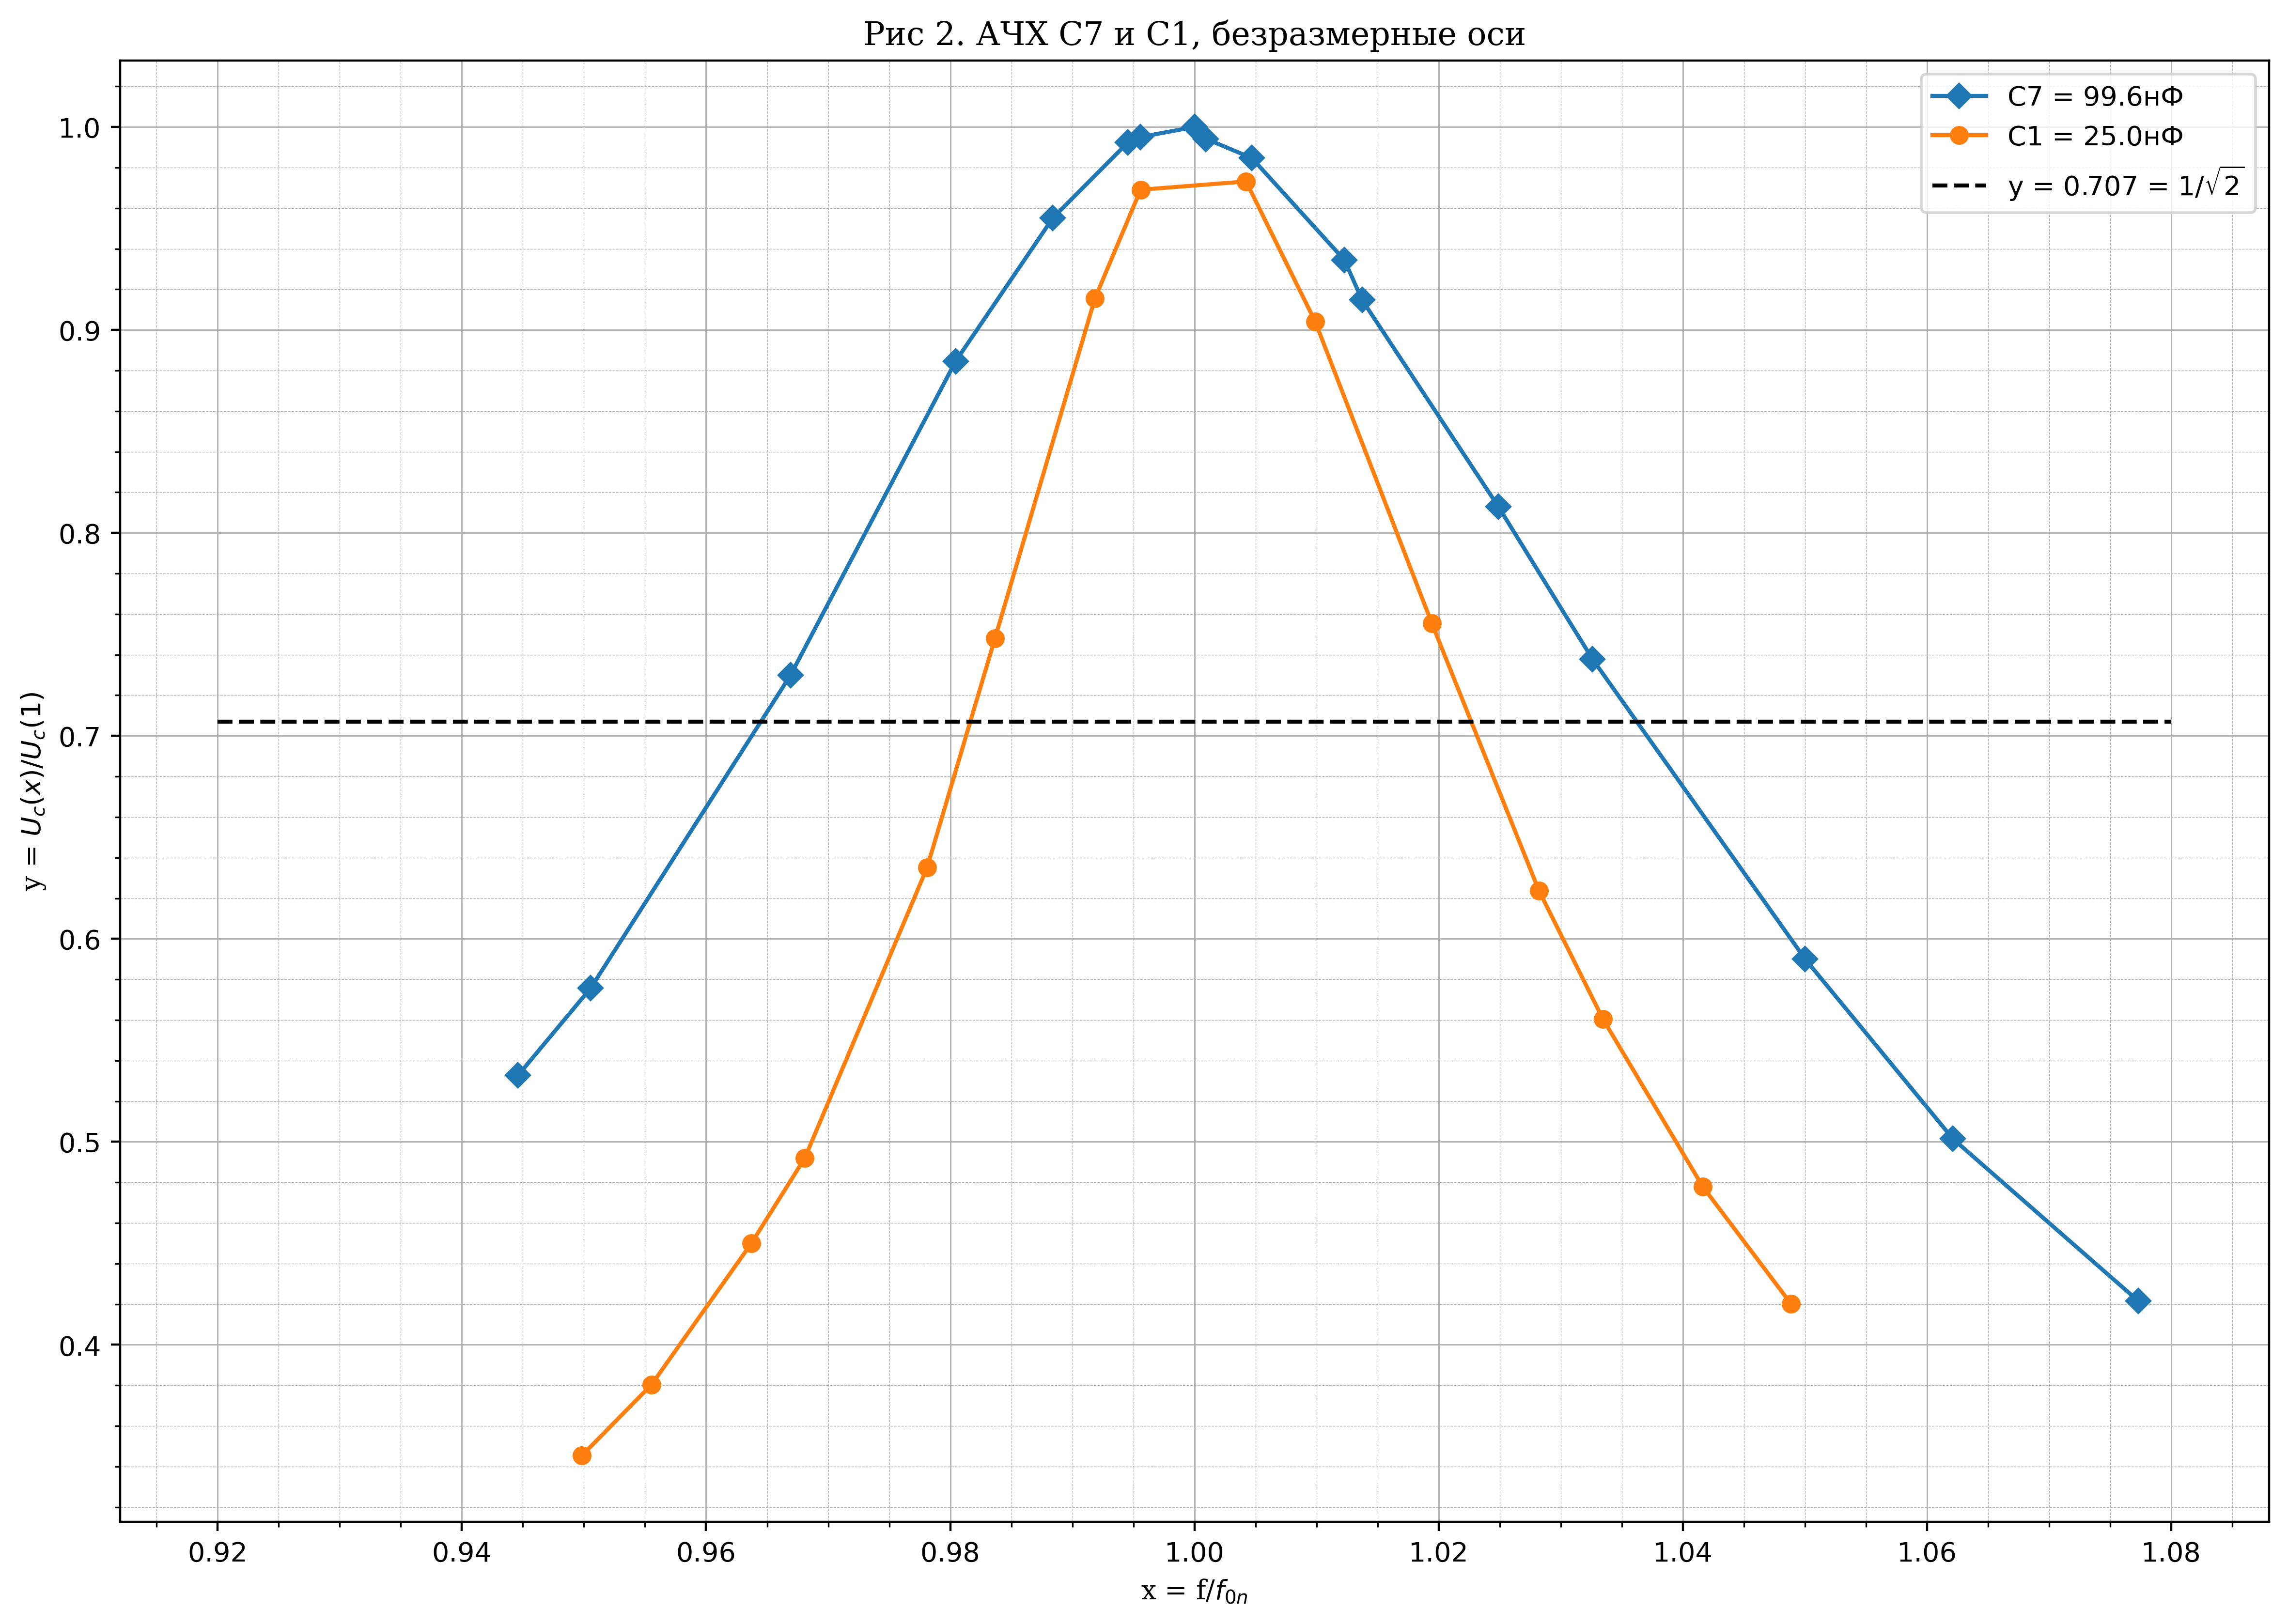

In [5]:
figB = mg.make_figure(dpi_mode='high')
ax = figB.add_subplot()
mg.set_grids(figB)
mg.set_label( ax, 'x = f/$f_{0n}$', 'y = $U_c(x)/U_c(1)$' )
mg.set_title(ax, 'АЧХ C7 и C1, безразмерные оси')

f01 = 31.272
U01 = 6.144 # * np.sqrt(2)
f07 = 15.955
U07 = 3.5193 # * np.sqrt(2)

sorted_c7 = dfc7a.sort_values(by=['f, kHz'])    # So that plot draws correctly.
sorted_c1 = dfc1a.sort_values(by=['f, kHz']) 
ax.plot( sorted_c7['f, kHz'] / f07, sorted_c7['U, V'] / U07, label='C7 = 99.6нФ', marker='D' )
ax.plot( sorted_c1['f, kHz'] / f01, sorted_c1['U, V'] / U01, label='C1 = 25.0нФ', marker='o' )
ax.plot( np.linspace(0.92, 1.08, 2), [0.707, 0.707], label='y = 0.707 = 1/$\sqrt{2}$', color='k', linestyle='dashed' )
ax.legend()

w2 = 1.035 + 0.2143 * 0.005
w1 = 0.965 - 0.1429 * 0.005
Q = 1 / (w2 - w1)
sigma_dw = 0.5 * (0.005 / 6)
sigma_Q = sigma_dw / ( (w2-w1)*(w2-w1) )
print(f'Добротность контура с C7 = {Q} +- {sigma_Q}')

w2 = 1.02 + 0.53125 * 0.005
w1 = 0.98 + 0.3125 * 0.005
Q = 1 / (w2 - w1)
sigma_dw = 0.5 * (0.005 / 6) # 6мм линейки - одно деление шкалы x.
sigma_Q = sigma_dw / ( (w2-w1)*(w2-w1) )
print(f'Добротность контура с C1 = {Q} +- {sigma_Q}')

Добротность контура с C7 = 15.802469135802426 +- 0.1040491794949951
Добротность контура с C1 = 24.549787582962868 +- 0.25112169598691575


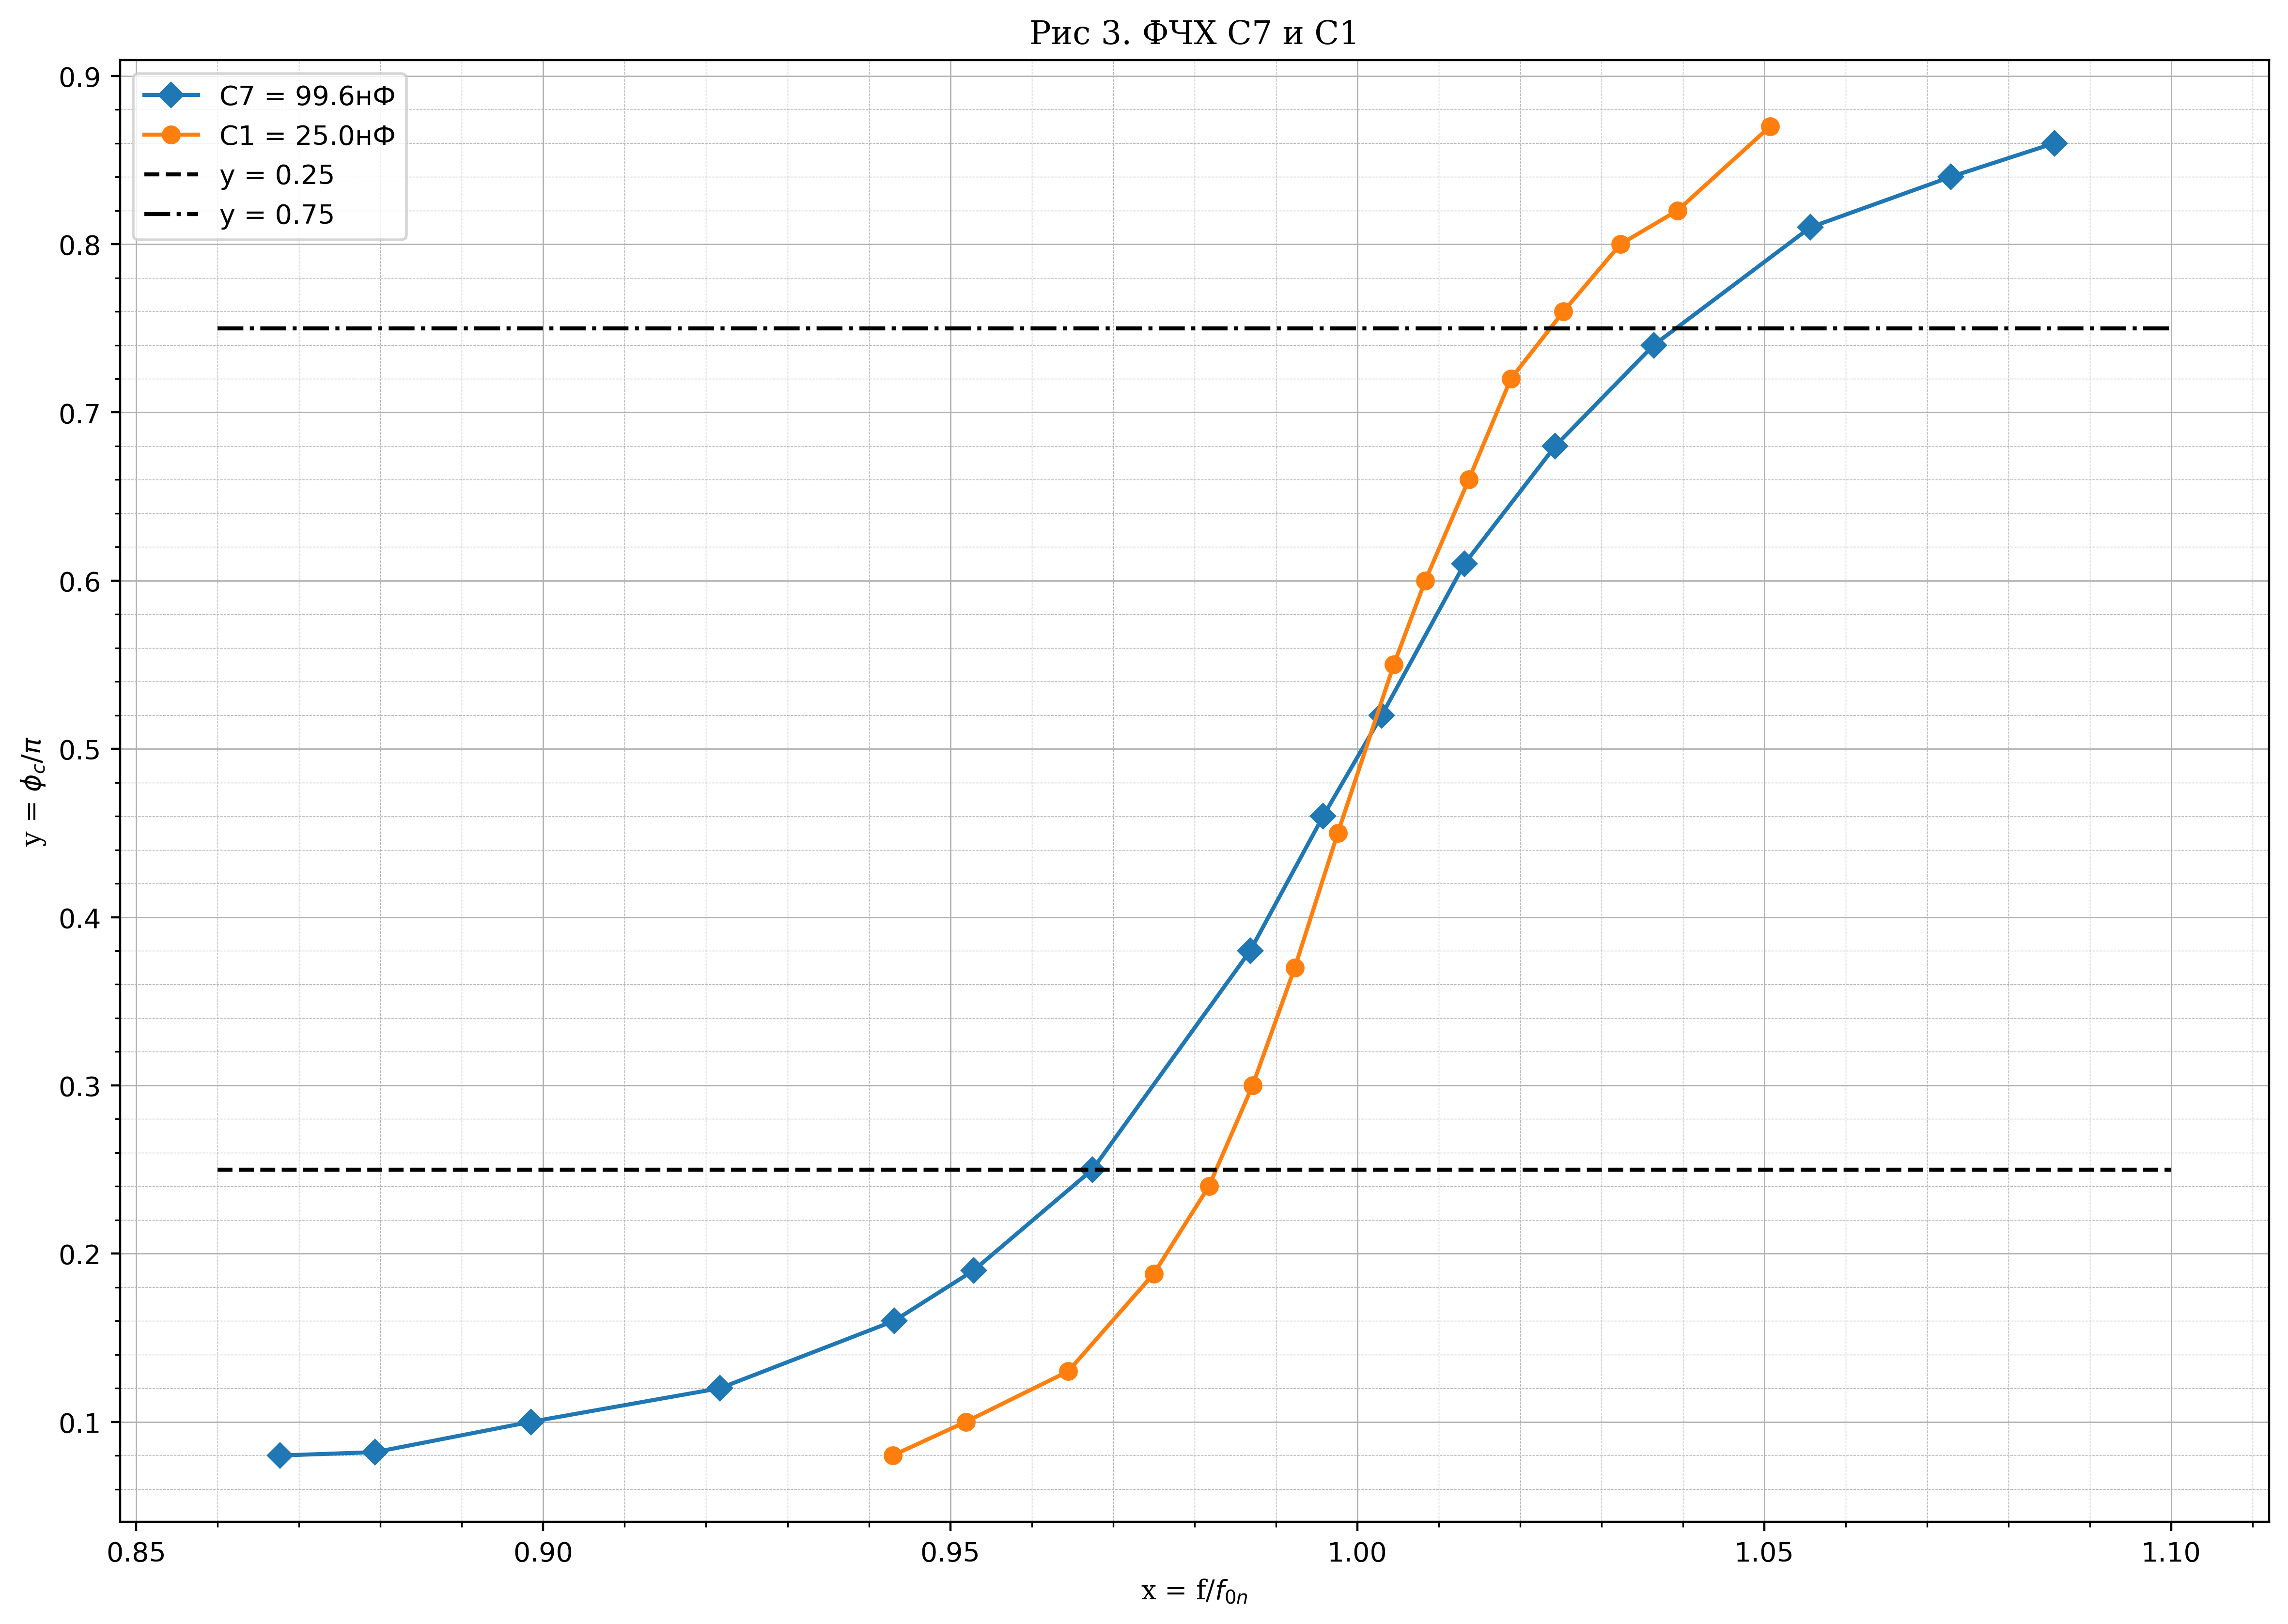

In [6]:
import pandas as pd
import mygraph as mg
import matplotlib.pyplot as plt

filename = 'c1phase.tsv'
dfc1ph = pd.read_csv(filename, sep='\t')
dfc1ph.index = np.arange(1,17)
filename = 'c7phase.tsv'
dfc7ph = pd.read_csv(filename, sep='\t')
dfc7ph.index = np.arange(1, 17)

figC = mg.make_figure(dpi_mode='high')
ax = figC.add_subplot()
mg.set_grids(figC)
mg.set_label(ax, 'x = f/$f_{0n}$', 'y = $\phi_c/\pi$')
mg.set_title(ax, 'ФЧХ C7 и C1')

f01 = 31.272
f07 = 15.955
sorted_c7 = dfc7ph.sort_values(by=['f, kHz'])    # So that plot draws correctly.
sorted_c1 = dfc1ph.sort_values(by=['f, kHz']) 
ax.plot( sorted_c7['f, kHz'] / f07, sorted_c7['dphi'], label='C7 = 99.6нФ', marker='D' )
ax.plot( sorted_c1['f, kHz'] / f01, sorted_c1['dphi'], label='C1 = 25.0нФ', marker='o' )
ax.plot( np.linspace(0.86, 1.1, 2), [1/4, 1/4], label='y = 0.25', color='k', linestyle='dashed' )
ax.plot( np.linspace(0.86, 1.1, 2), [3/4, 3/4], label='y = 0.75', color='k', linestyle='dashdot' )
ax.legend()

x2 = 1.04 - 0.9375 * 0.01
x1 = 0.97 - 0.265625 * 0.01
Q = 1 / (x2 - x1)
sigma_dx = 0.5 * (0.005 / 6)
sigma_Q = sigma_dx / ( (x2-x1)*(x2-x1) )
print(f'Добротность контура с C7 = {Q} +- {sigma_Q}')

x2 = 1.02 + 0.33898 * 0.01
x1 = 0.98 + 0.265625 * 0.01
Q = 1 / (x2 - x1)
sigma_dx = 0.5 * (0.005 / 6) # 6мм линейки - одно деление шкалы x.
sigma_Q = sigma_dx / ( (x2-x1)*(x2-x1) )
print(f'Добротность контура с C1 = {Q} +- {sigma_Q}')

,"f, kHz","R_L, Ом"
7,15.955,3.581476
6,17.535,3.880526
5,19.330,4.548075
4,20.898,4.265931
3,22.864,4.167671
2,27.313,4.564503
1,31.272,4.666361


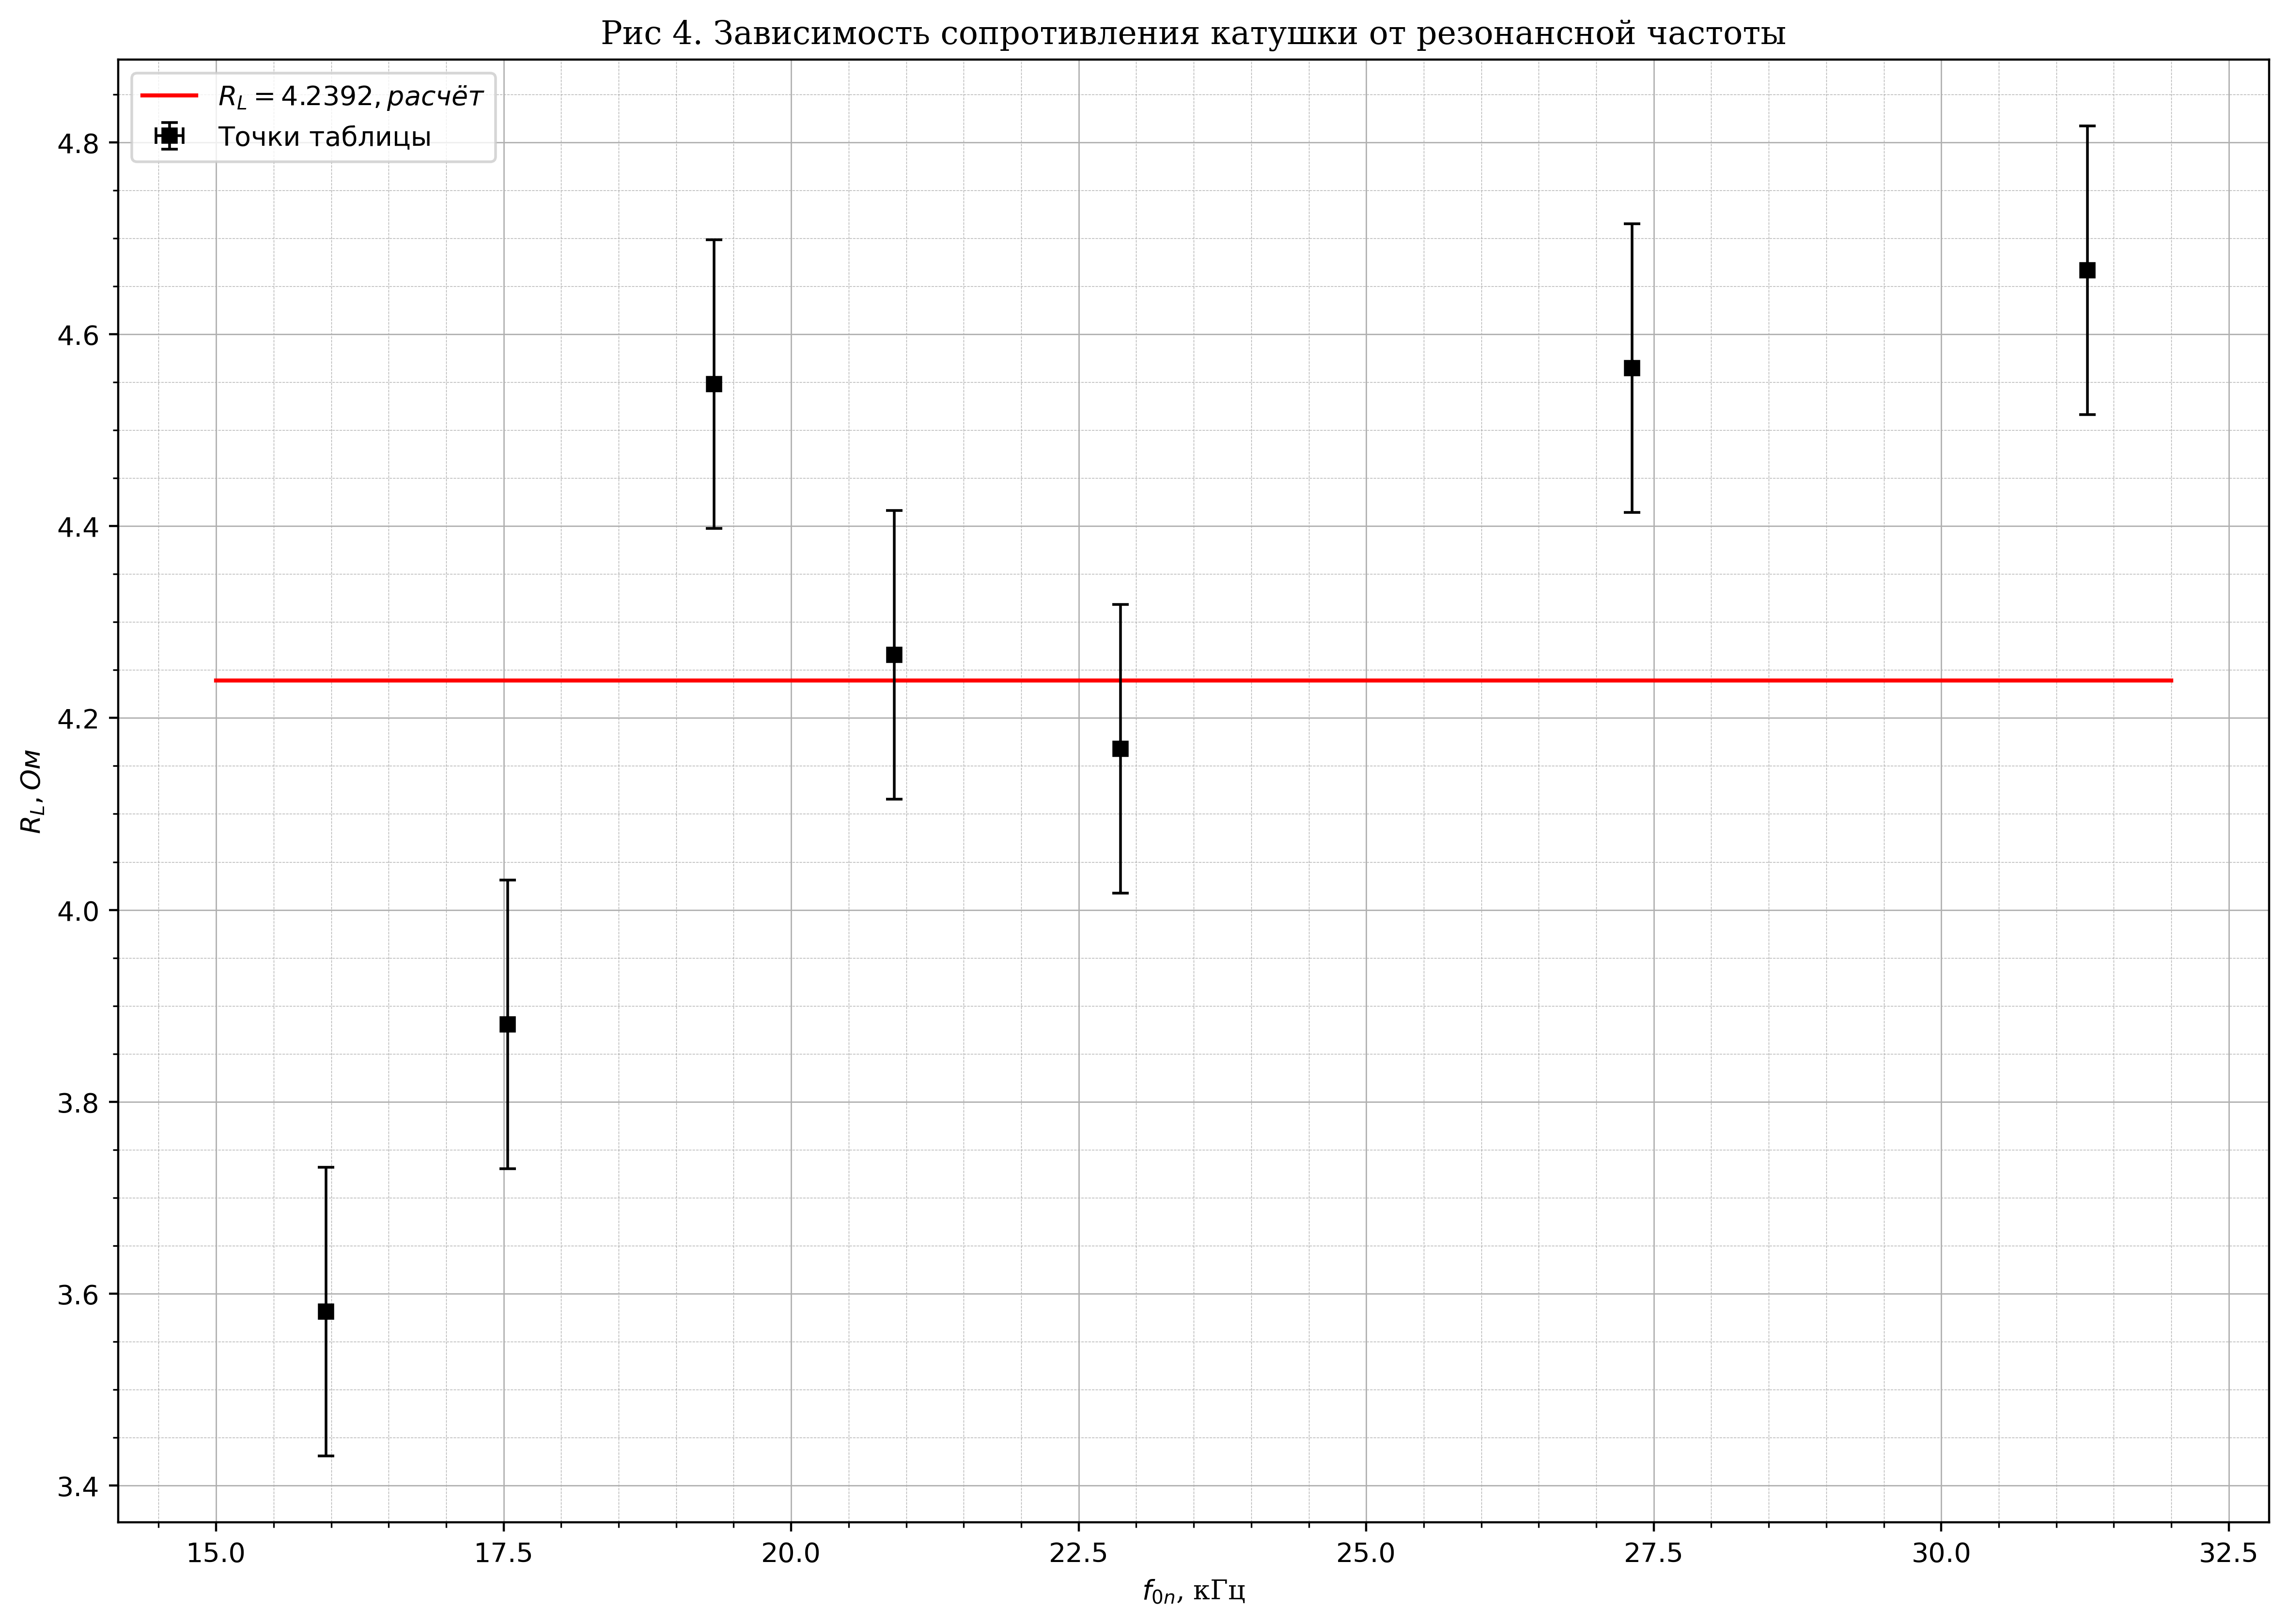

In [7]:
dfs = df[ ['f, kHz','R_L, Ом'] ]
figD = mg.make_figure(dpi_mode='high')
ax = figD.add_subplot()
mg.set_grids(figD)
mg.set_label(ax, '$f_{0n}$, кГц', '$R_L, Ом$')
mg.set_title(ax, 'Зависимость сопротивления катушки от резонансной частоты')

f07 = dfs['f, kHz'][7]
#ax.set_xlim(left=0.6 * f07)
mask = dfs['f, kHz'] > 31.272 * 0.6
dfs = dfs.sort_values(by=['f, kHz'])
mg.draw_errorbar(ax, dfs['f, kHz'], dfs['R_L, Ом'], 1/1000, ser['devR_L'], label='Точки таблицы')
# ax.scatter(dfs['f, kHz'], dfs['R_L, Ом'], marker='o', label='Точки таблицы')
ax.plot(np.linspace(15, 32, 2), [ser['R_L'], ser['R_L']], color='r', label=f"$R_L = {ser['R_L']:.4f}, расчёт$")
ax.legend()
dfs

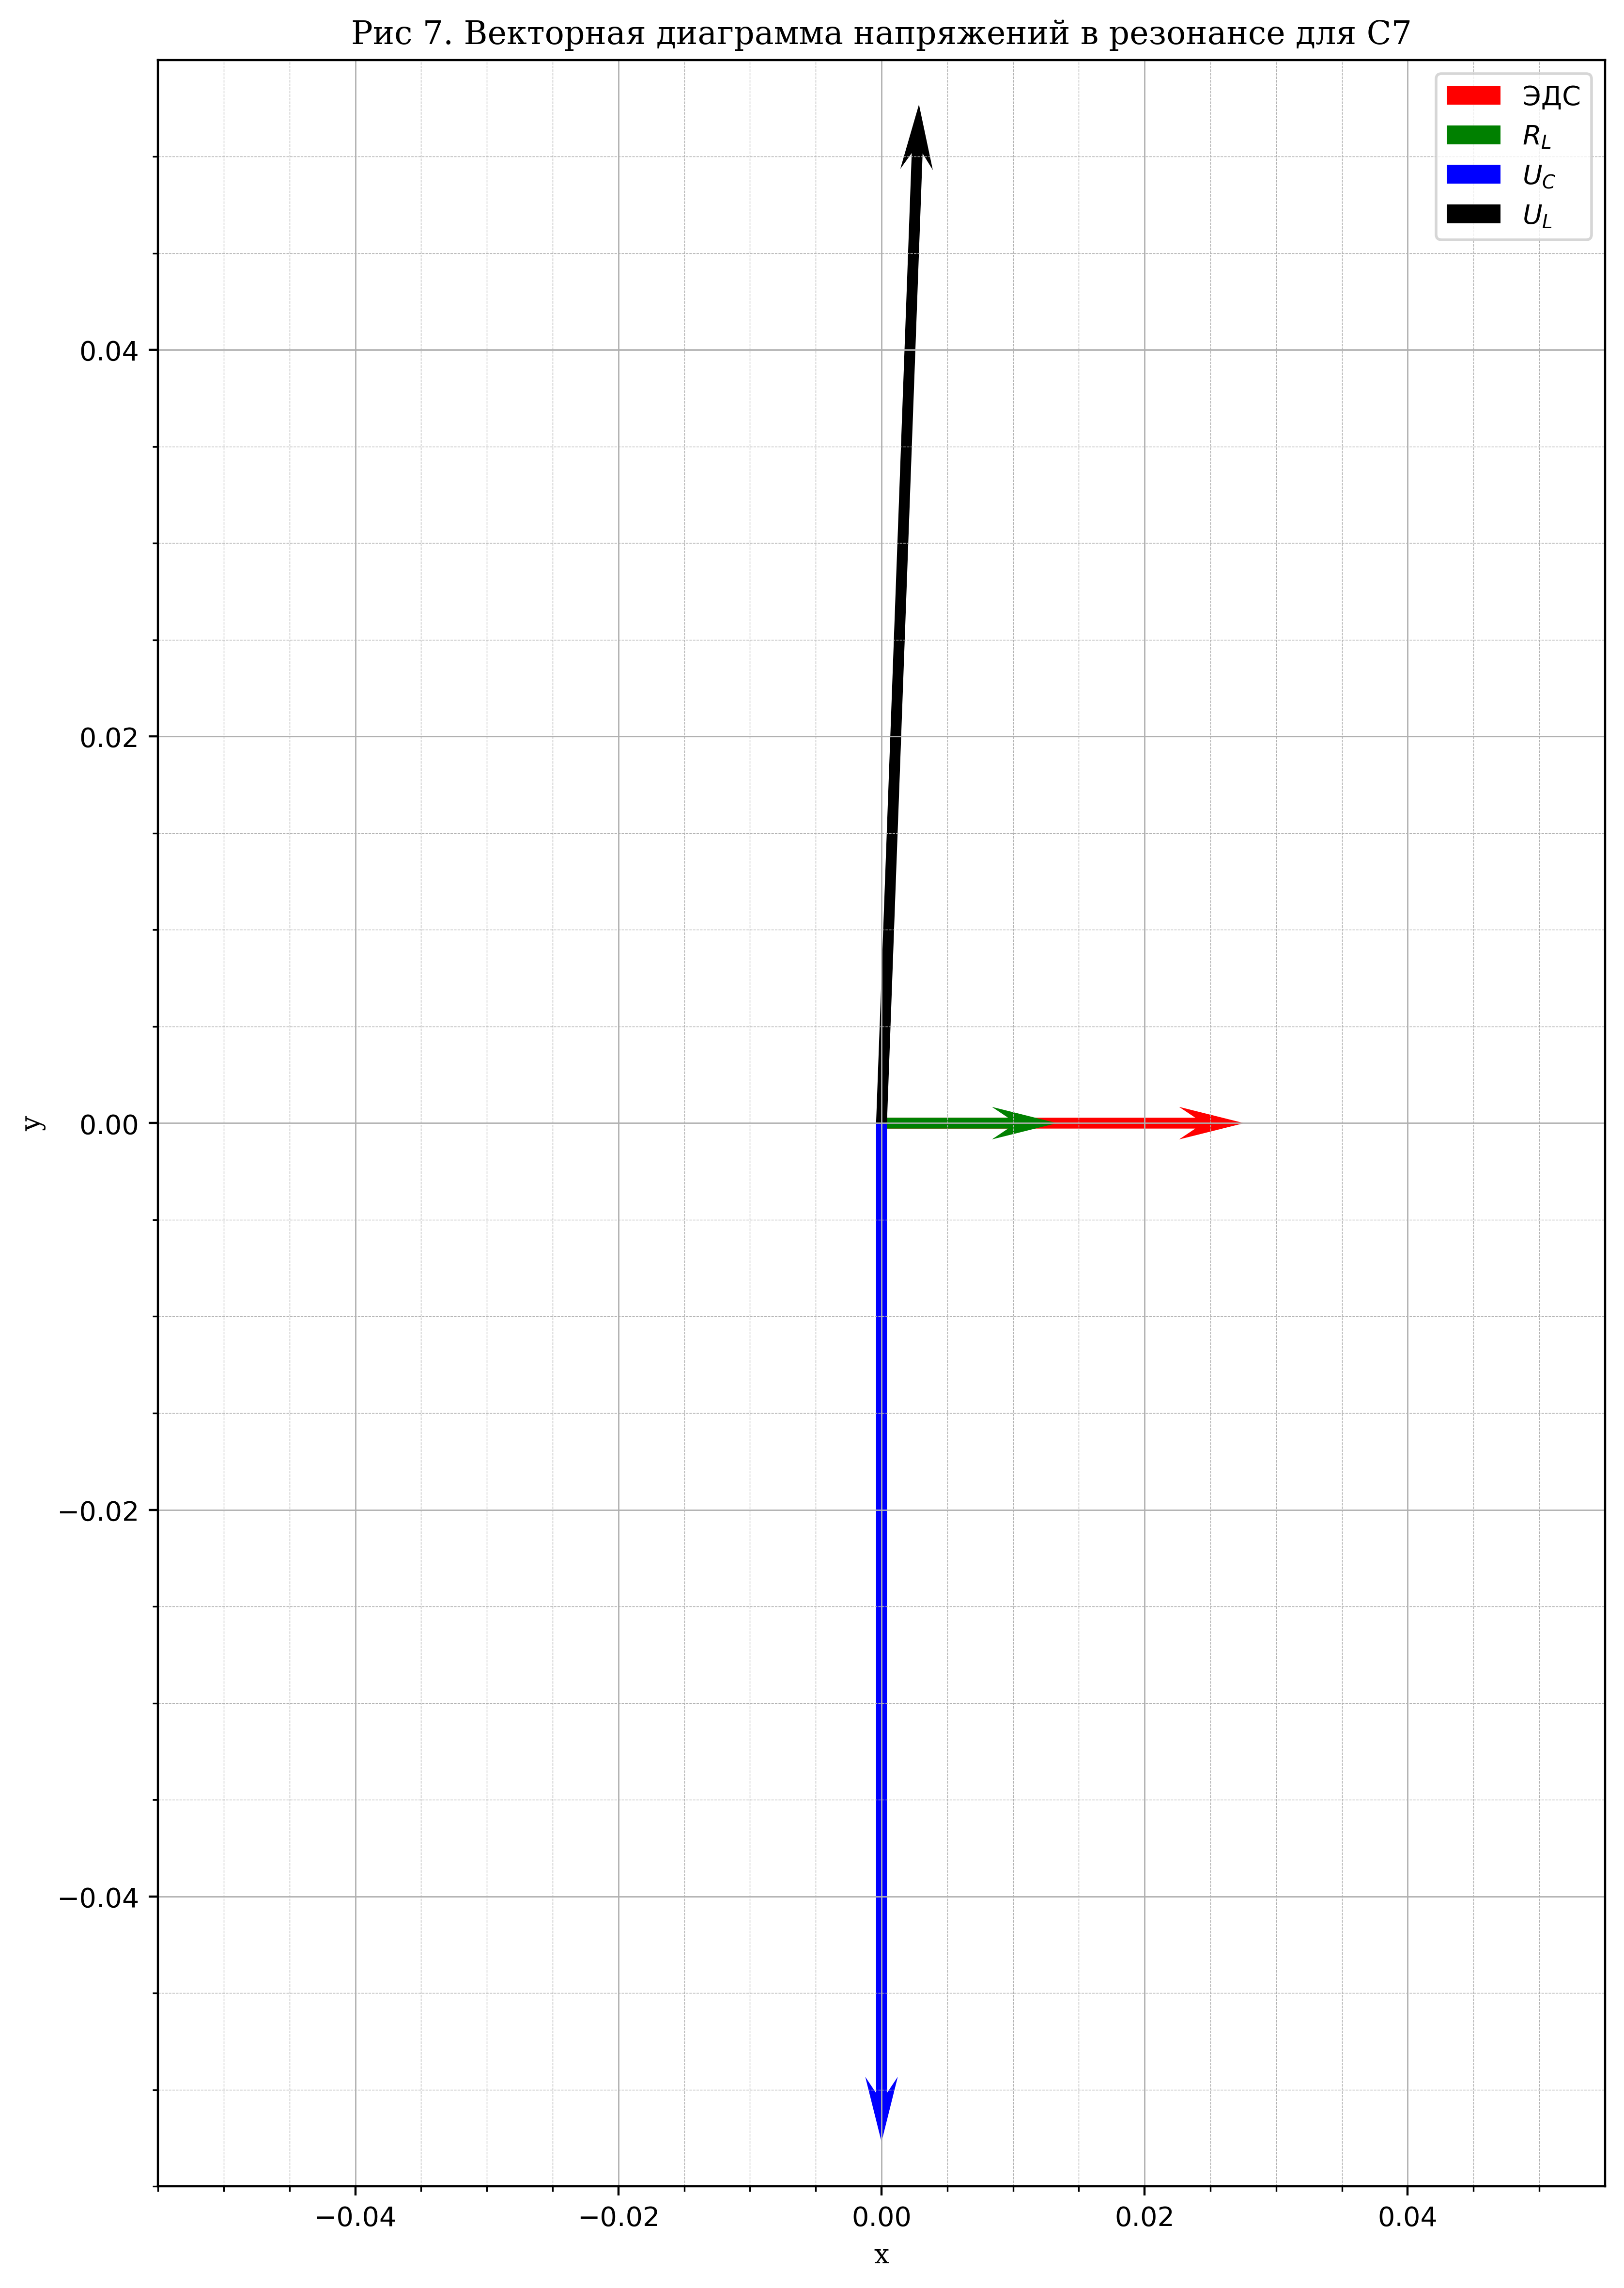

In [10]:
figE = mg.make_figure(dpi_mode='high', orientation='portrait')
ax = figE.add_subplot()
mg.set_grids(figE)
mg.set_label(ax, 'x', 'y')
mg.set_title(ax, 'Векторная диаграмма напряжений в резонансе для C7')
 
epsX, epsY = df['E, V'][7], 0
urX, urY = df['I, мА'][7] * 1e-3 * 3.45, 0
ucX, ucY = 0, -df['U, V'][7]
ulX, ulY = epsX - urX - ucX, epsY - urY - ucY  
u, v = [epsX, urX, ucX, ulX], [epsY, urY, ucY, ulY]
ax.quiver([0], [0], u[0], v[0], scale=1, color=['r'], label='ЭДС', headwidth=3, headlength=6)
ax.quiver([0], [0], u[1], v[1], scale=1, color=['g'], label='$R_L$', headwidth=3, headlength=6)
ax.quiver([0], [0], u[2], v[2], scale=5, color=['b'], label='$U_C$', headwidth=3, headlength=6)
ax.quiver([0], [0], u[3], v[3], scale=5, color=['k'], label='$U_L$', headwidth=3, headlength=6)


ax.legend()